In [2]:
from __future__ import print_function, division
import os
import torch
from numpy import newaxis
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from dataset_generator_2 import Dataset_sat
from data_augmentation import Flip,Rotate,Rescale,ToTensor
import h5py
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from imgaug import augmenters as iaa
plt.ion()   # interactive mode
from image_utils import read_data_h5,standardize
from torch.autograd import Variable

/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
PATH_INPUT='INPUT/'
PATH_OUTPUT='OUTPUT/'
NB_CLASSES=2


In [3]:
class Flip2(object):
    """Flip ratio of the image Left/Right and up/down

    Args:
        ratio (int): how much of the image is flipped
    """

    def __init__(self,ratio):

        self.ratio = ratio

    def __call__(self, sample):
        X, Y = sample['input'], sample['groundtruth']
        
        seq = iaa.Sequential([iaa.Fliplr(0.5),iaa.Flipud(0.5)])
        data_tot=np.concatenate((X.astype('uint8'),Y.astype('uint8')),axis=2)
        data_tot=seq.augment_images(data_tot[newaxis,:,:,:])
        data_tot=np.squeeze(data_tot)
        X=data_tot[:,:,:X.shape[2]]
        Y=data_tot[:,:,X.shape[2]:]
        return {'input': X, 'groundtruth': Y}
    

In [66]:
 class Rotate2(object):
    """Rotate of random angle between 0 and max_rot of the image

    Args:
        max_rot (int): how much of the image is rotated
    """

    def __init__(self,max_rot):

        self.max_rot = max_rot
    def __call__(self, sample):   
        
        X, Y = sample['input'], sample['groundtruth']
        seq = iaa.Sequential(iaa.Affine(rotate=(0, self.max_rot)))
        X,Y=(X-np.amin(X))/(np.amax(X)-np.amin(X))*255,(Y-np.amin(Y))/(np.amax(Y)-np.amin(Y))*255
        data_tot=np.concatenate((X.astype('uint8'),Y.astype('uint8')),axis=2)
        data_tot=seq.augment_images(data_tot[newaxis,:,:,:])
        data_tot=np.squeeze(data_tot)
        X=data_tot[:,:,:X.shape[2]]
        Y=data_tot[:,:,X.shape[2]:]
        X,Y=(X-np.amin(X))/(np.amax(X)-np.amin(X)),(Y-np.amin(Y))/(np.amax(Y)-np.amin(Y))
        return {'input': X, 'groundtruth': Y}

In [37]:
def _parse_image(path_input,path_output,nb_classes):
    '''
    Reads and saves as as an array image input and output
    :paths_input path of the input image that have to be read  
    :paths_output path of the output image that have to be read  
    returns input and output image as array
    '''
    
    X=read_data_h5(path_input)
    Y_build=read_data_h5(path_output)
    Y_build=(Y_build>0).astype(int)
    Y_other= (1-Y_build).astype(int)
    Y=np.stack((Y_build,Y_other),axis=2)
            
#     inp=torch.LongTensor(Y_build)
#     inp_ = torch.unsqueeze(inp, len(Y_build.shape))
#     Y = torch.FloatTensor(Y_build.shape[0],Y_build.shape[1],nb_classes ).zero_()
#     Y.scatter_(len(Y_build.shape), inp_, 1)
#     Y=np.asarray(Y)
# OR
#     Y_build=torch.LongTensor(Y_build)
#     y_tensor = Y_build.data if isinstance(Y_build, Variable) else Y_build
#     y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
#     y_one_hot = torch.zeros(y_tensor.size()[0], nb_classes).scatter_(1, y_tensor, 1)
#     Y = y_one_hot.view(*Y_build.shape, -1)
    
    return X,Y

In [38]:
class Dataset_sat(Dataset):
    """Satellite images dataset with rastered footprints in groundtruth."""

    def __init__(self,paths_input: np.ndarray,paths_output: np.ndarray,nb_classes: int,transform=None):
        """
        Args:
            
        """
        self.paths_input = paths_input
        self.paths_output = paths_output
        self.nb_classes=nb_classes
        self.transform = transform
    @classmethod
    def from_root_folder(cls, root_folder: str, nb_classes: int,*,transform=None, max_data_size:  int = None):
        paths_input = []
        paths_output=[]
        
        
        for filename in sorted(os.listdir(root_folder+PATH_INPUT))[:max_data_size]:
            paths_input.append(os.path.join(root_folder+PATH_INPUT, filename))

        for filename in sorted(os.listdir(root_folder+PATH_OUTPUT))[:max_data_size]:

            paths_output.append(os.path.join(root_folder+PATH_OUTPUT, filename))
        
        
        return Dataset_sat(np.asarray(paths_input), np.asarray(paths_output),nb_classes)

    def __len__(self):
        return len(self.paths_input)
    
#     def shuffled(self):
# #         if seed is not None:
# #             np.random.seed(seed)

#         idx = np.arange(len(self.paths_input))
#         np.random.shuffle(idx)
#         generator = Dataset_sat(self.paths_input[idx], self.paths_output[idx],self.nb_classes)

#         return generator 

    def __getitem__(self, idx):
        
        X,Y=_parse_image(self.paths_input[idx],self.paths_output[idx],self.nb_classes)     
        sample = {'input': X, 'groundtruth': Y}

        if self.transform:
            sample = self.transform(sample)

        return sample

200
200
50
200
0 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


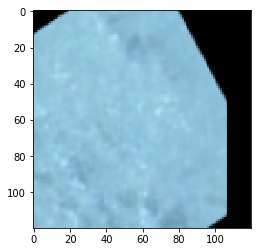

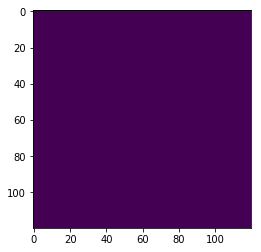

1 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


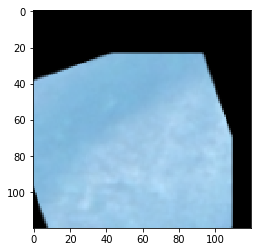

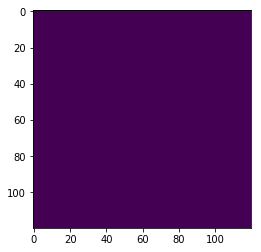

2 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


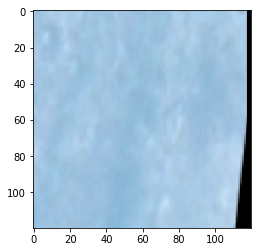

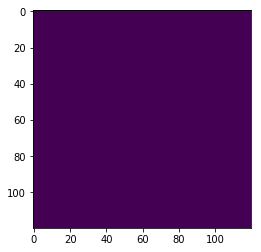

3 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


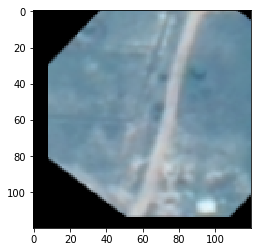

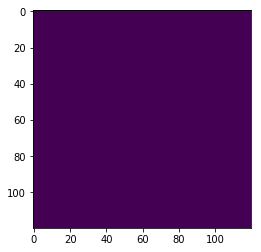

4 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


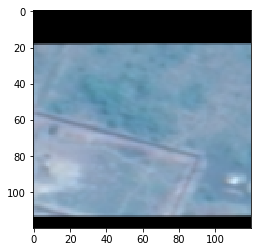

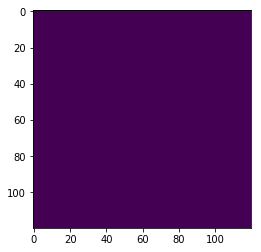

5 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


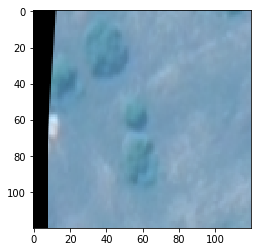

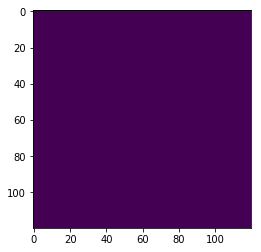

6 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


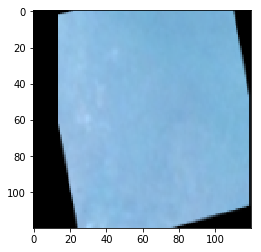

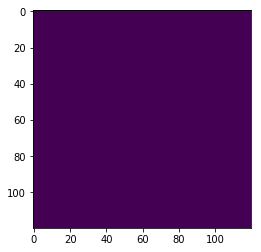

7 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


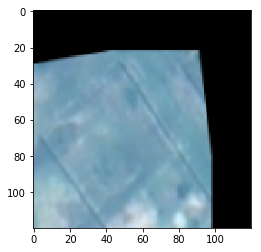

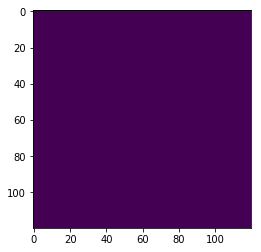

8 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


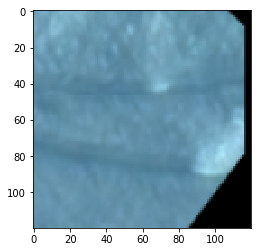

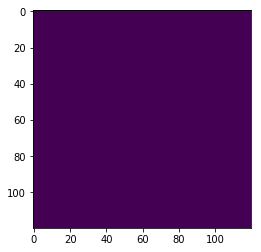

9 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


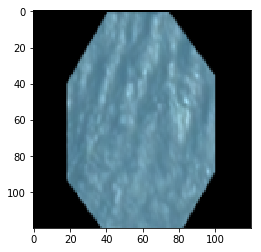

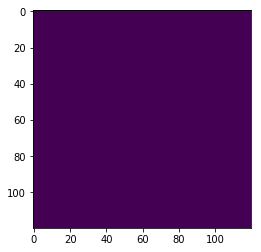

10 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


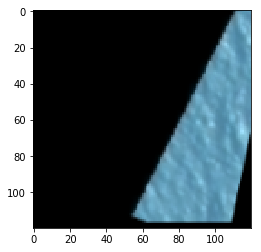

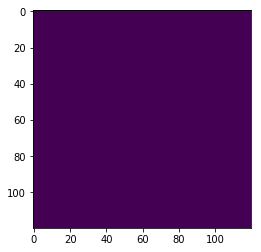

11 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


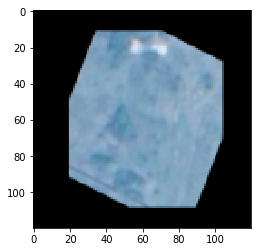

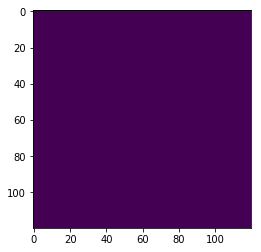

12 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


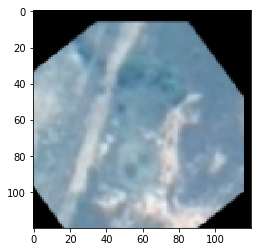

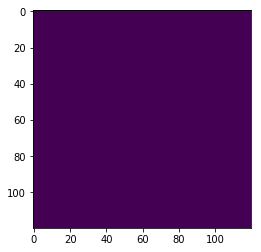

13 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


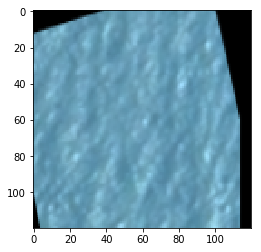

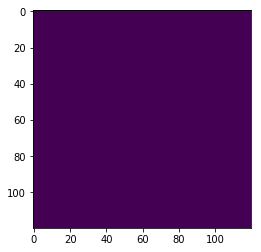

14 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


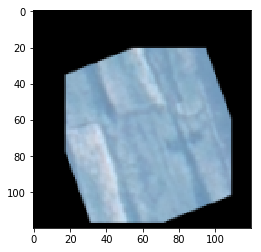

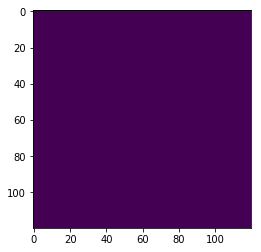

15 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


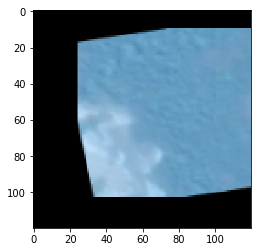

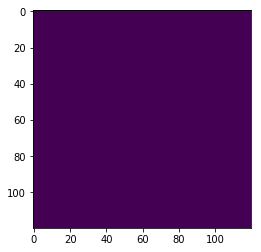

16 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


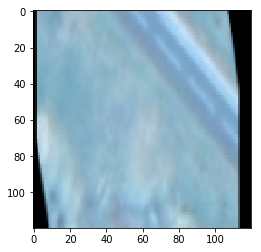

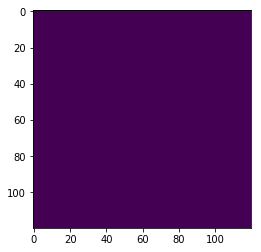

17 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


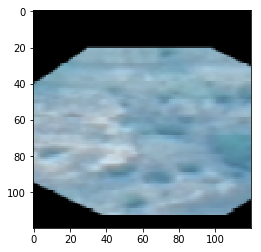

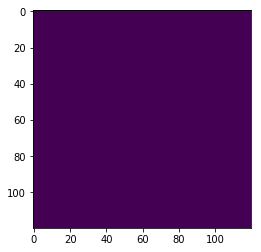

18 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


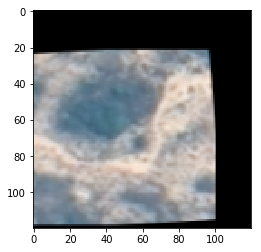

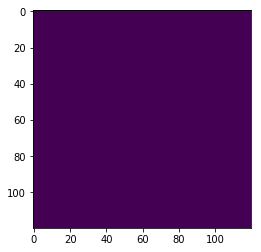

19 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


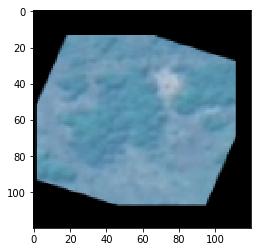

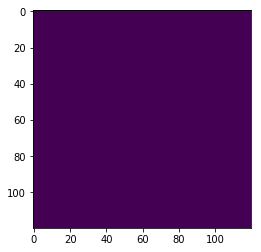

20 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


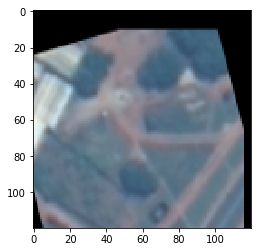

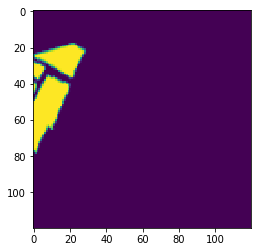

21 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


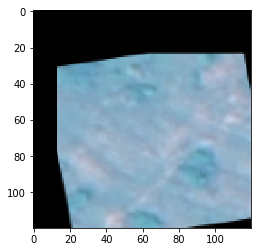

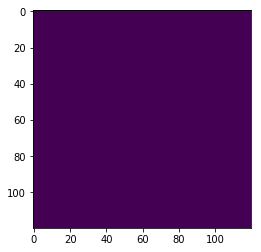

22 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


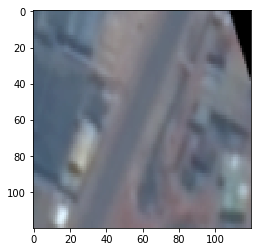

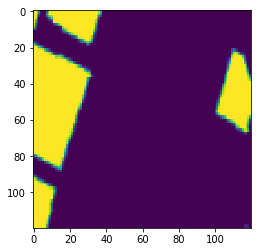

23 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


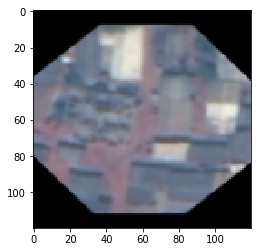

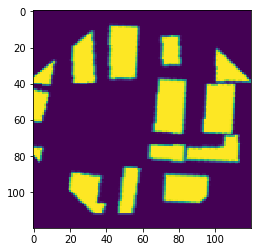

24 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


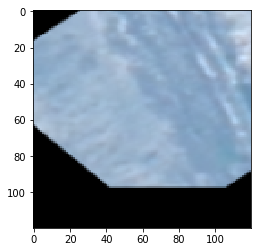

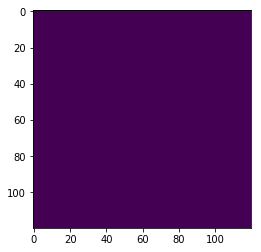

25 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


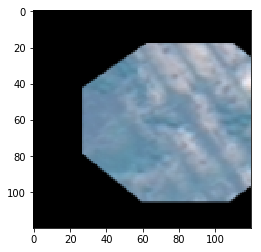

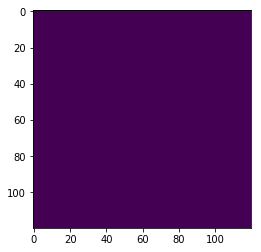

26 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


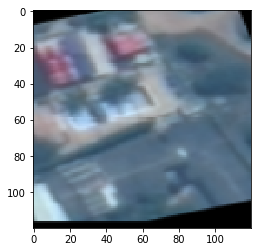

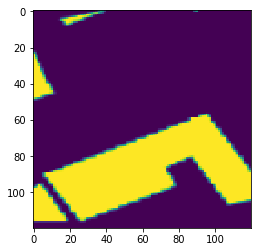

27 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


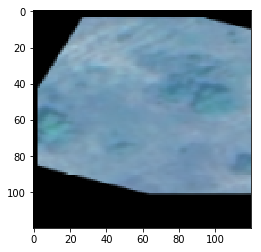

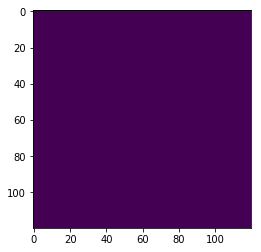

28 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


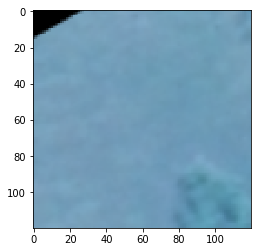

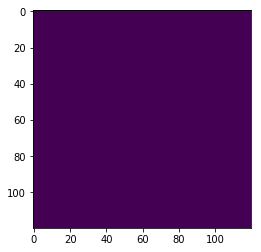

29 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


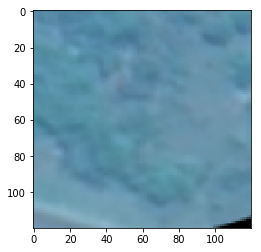

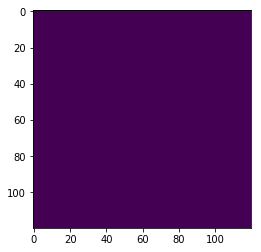

30 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


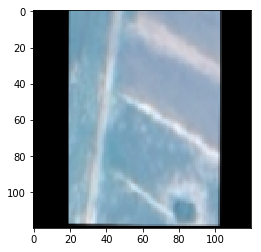

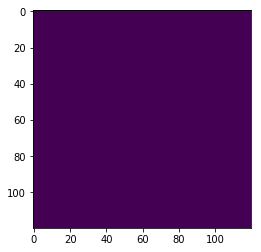

31 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


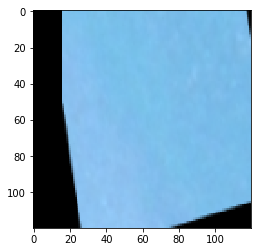

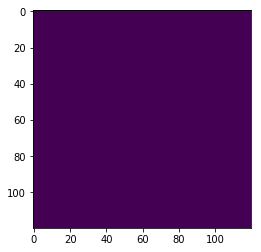

32 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


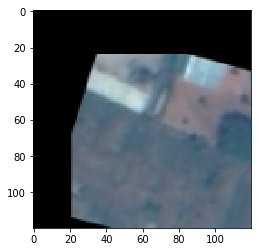

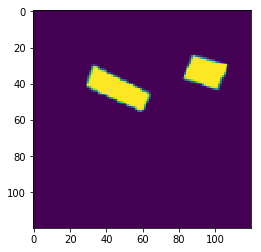

33 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


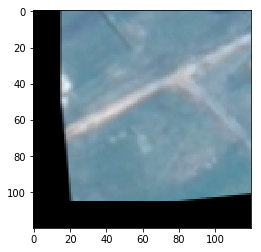

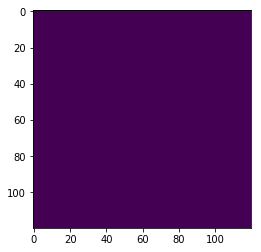

34 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


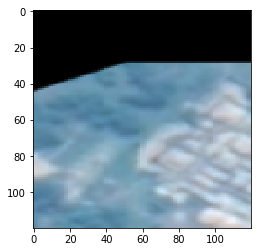

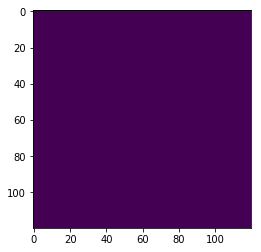

35 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


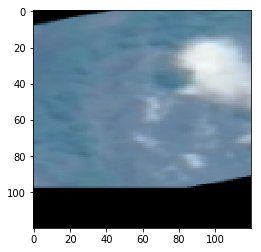

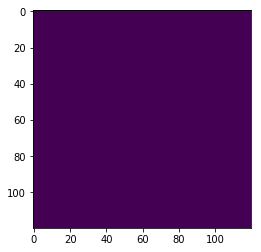

36 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


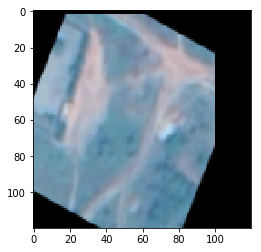

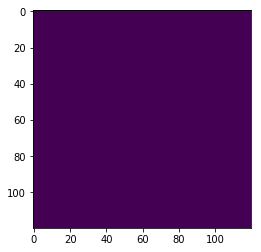

37 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


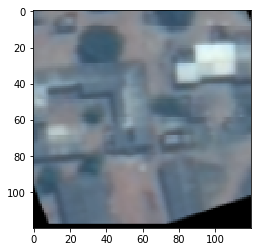

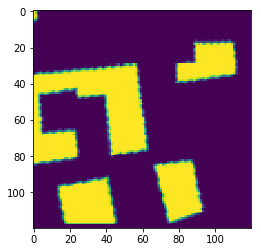

38 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


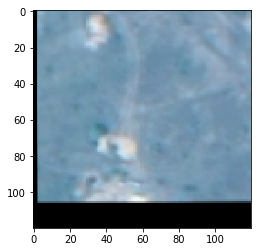

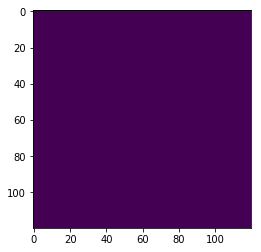

39 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


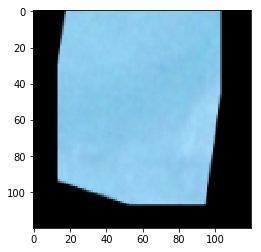

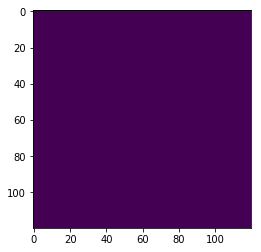

40 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


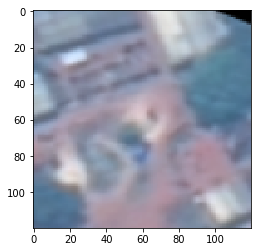

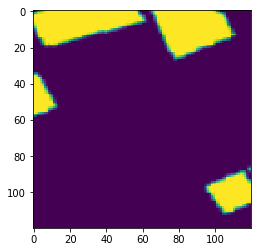

41 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


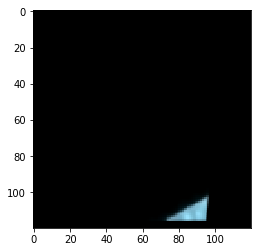

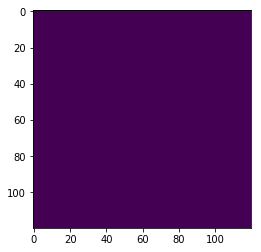

42 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


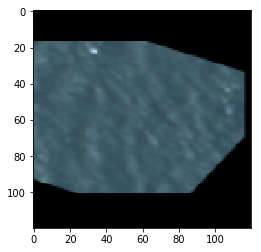

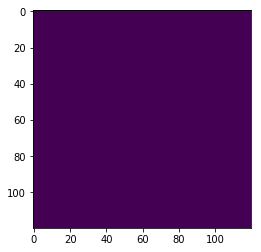

43 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


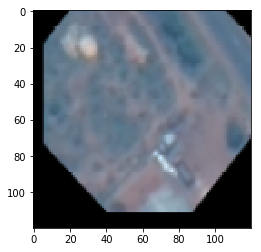

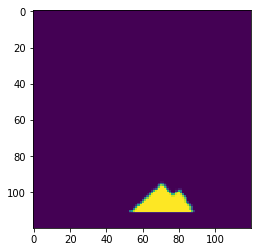

44 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


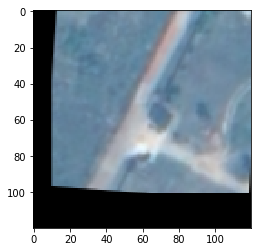

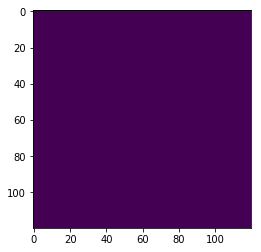

45 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


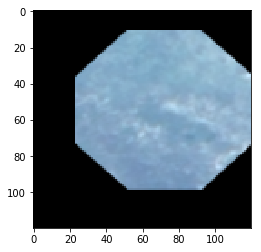

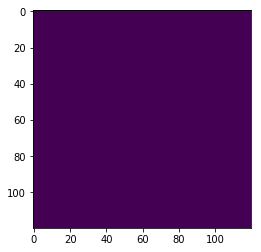

46 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


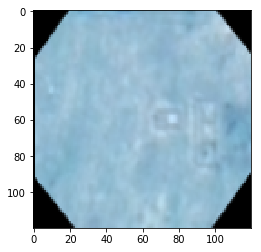

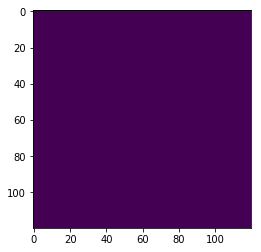

47 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


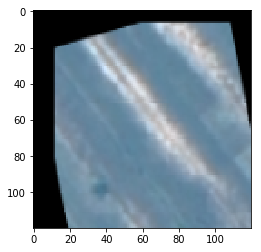

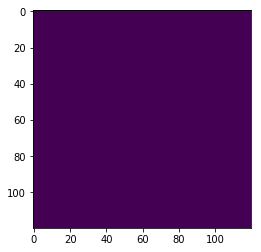

48 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


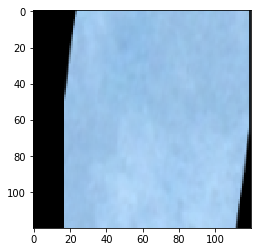

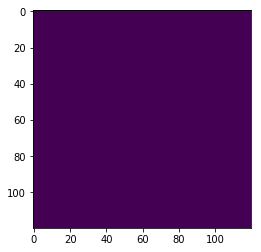

49 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


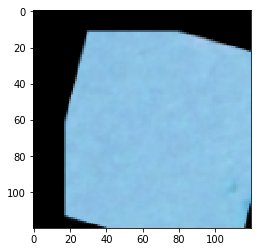

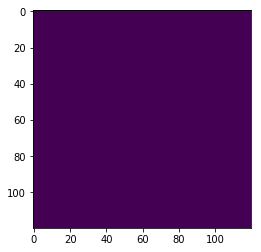

50 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


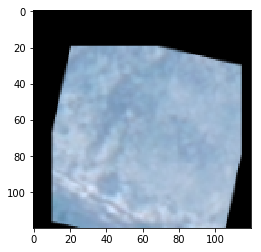

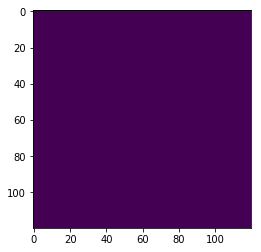

51 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


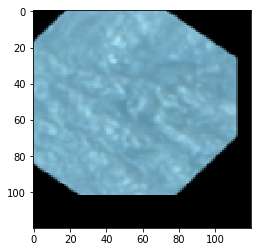

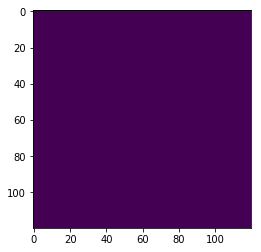

52 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


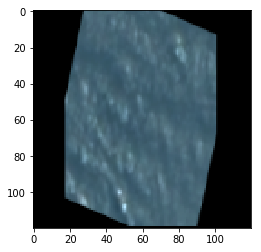

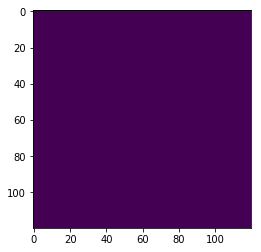

53 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


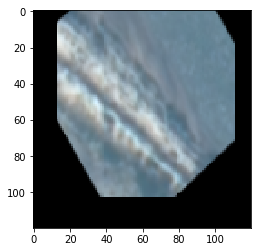

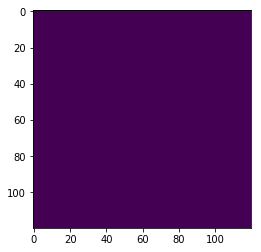

54 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


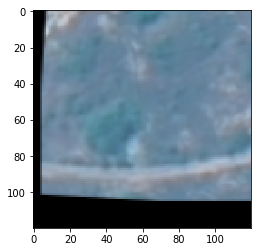

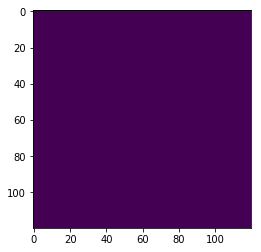

55 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


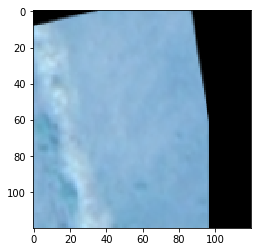

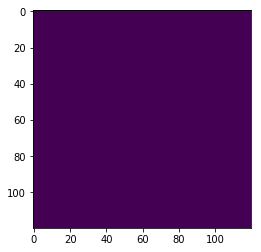

56 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


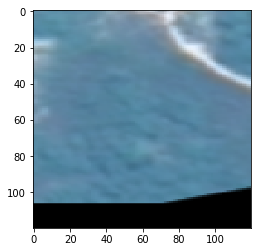

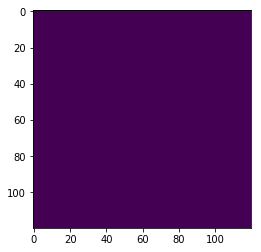

57 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


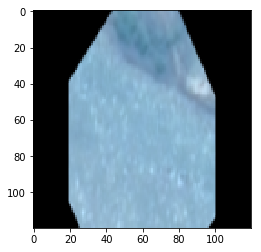

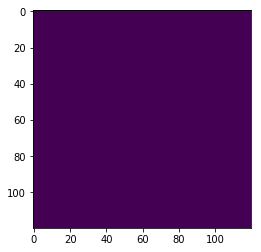

58 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


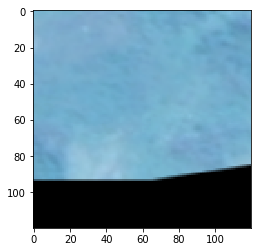

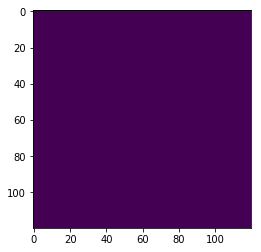

59 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


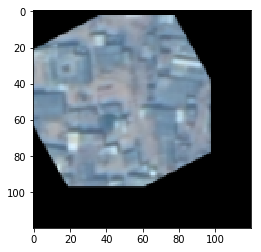

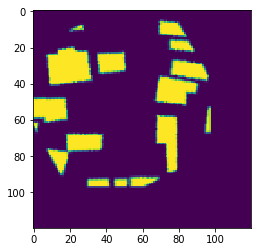

60 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


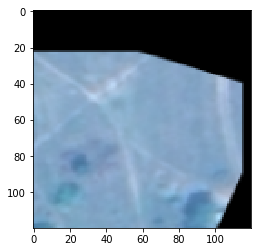

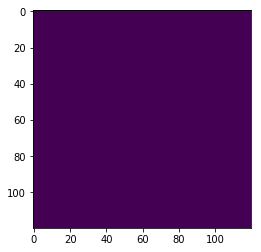

61 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


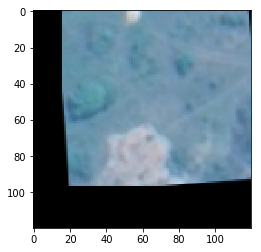

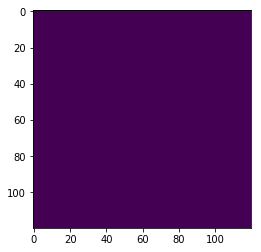

62 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


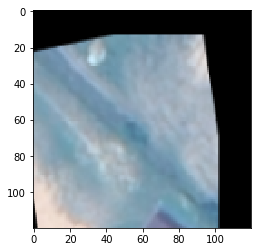

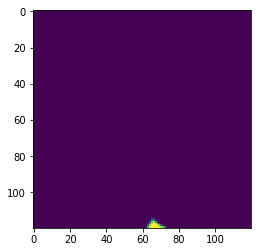

63 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


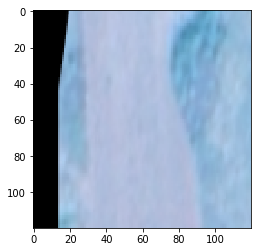

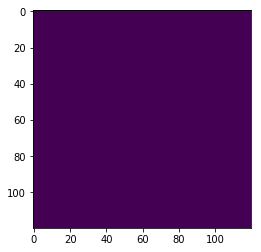

64 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


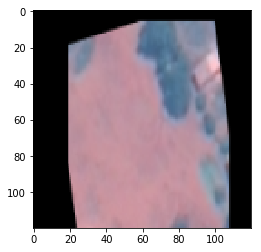

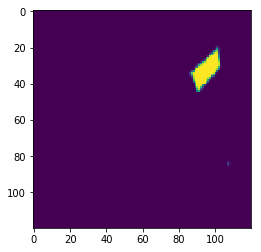

65 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


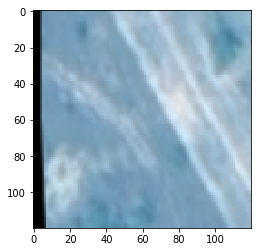

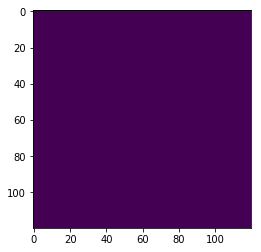

66 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


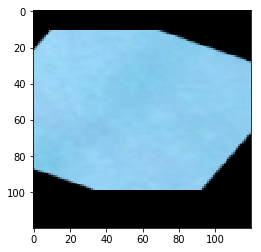

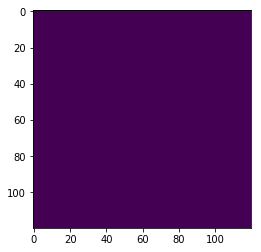

67 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


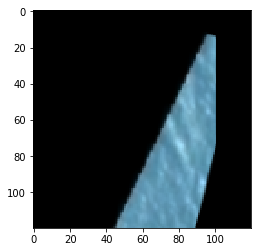

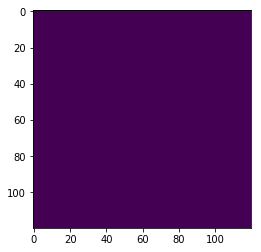

68 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


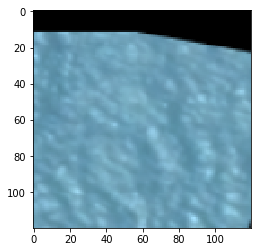

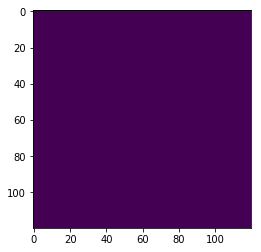

69 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


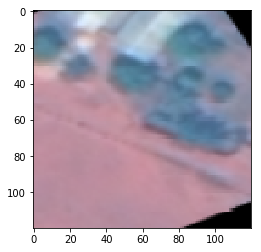

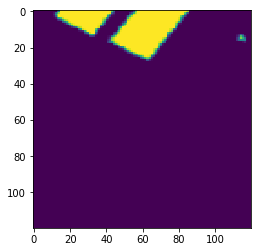

70 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


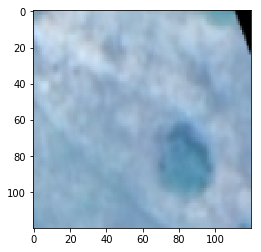

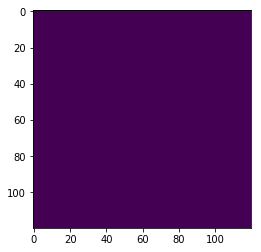

71 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


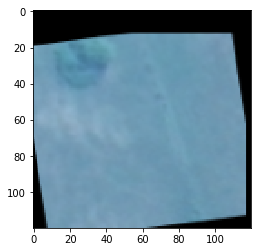

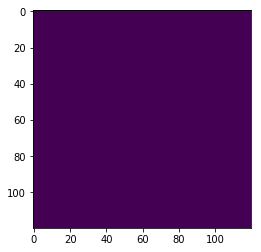

72 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


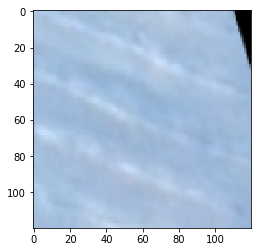

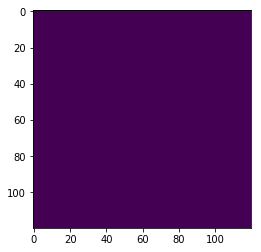

73 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


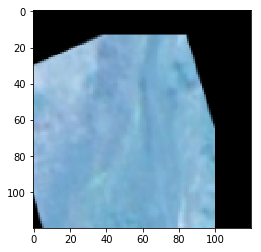

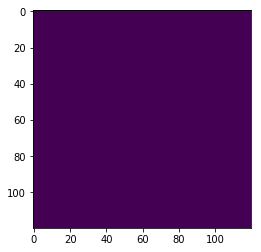

74 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


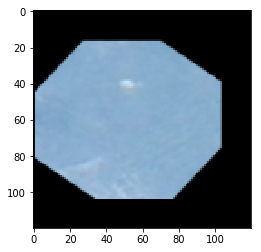

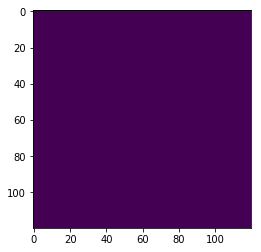

75 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


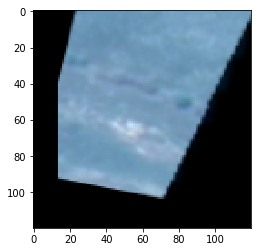

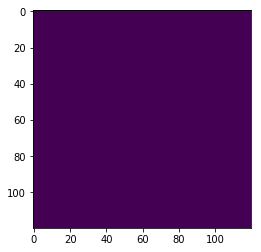

76 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


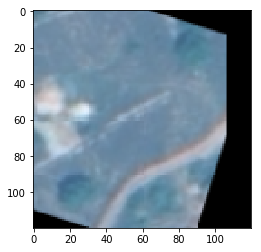

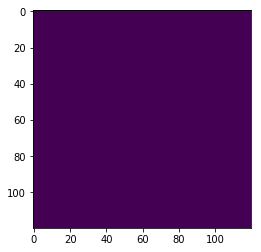

77 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


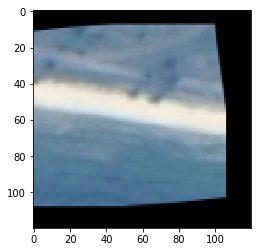

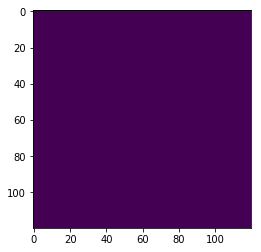

78 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


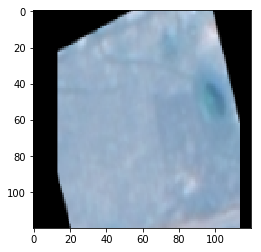

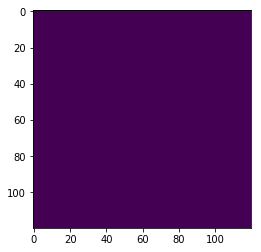

79 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


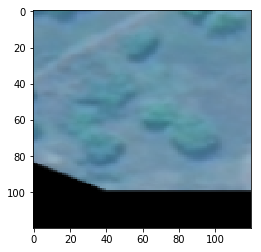

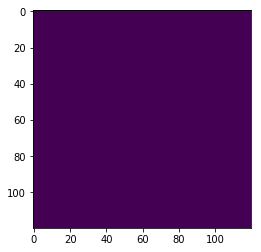

80 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


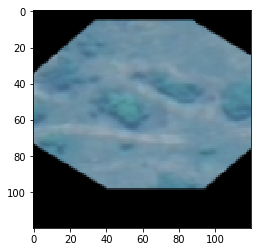

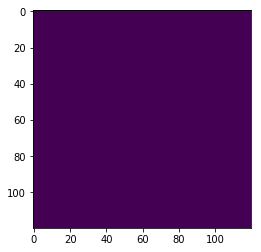

81 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


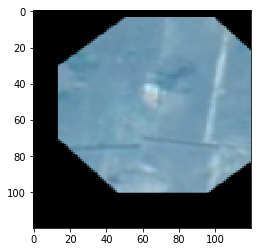

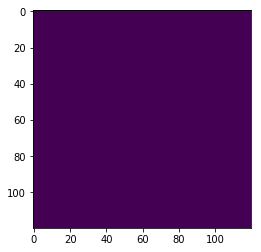

82 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


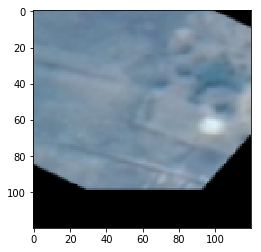

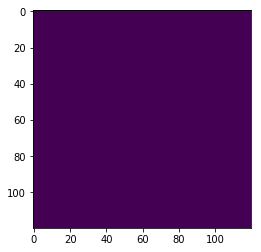

83 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


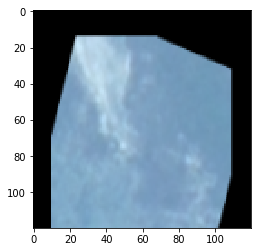

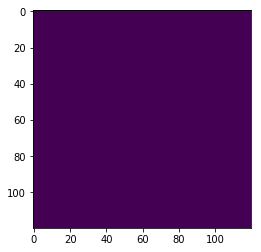

84 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


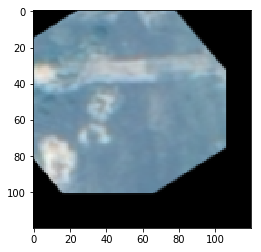

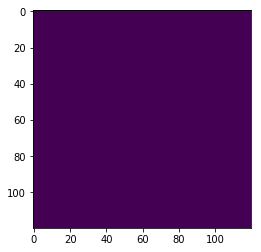

85 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


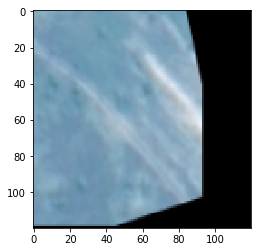

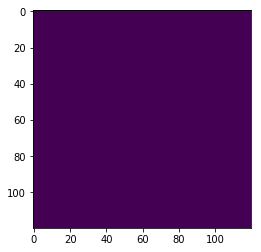

86 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


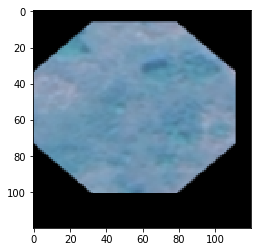

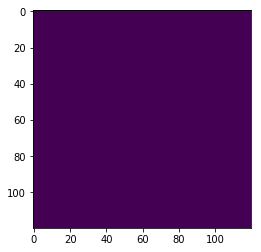

87 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


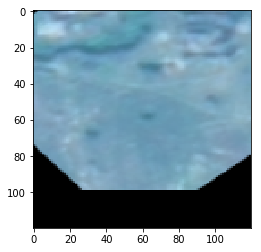

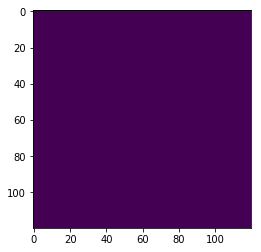

88 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


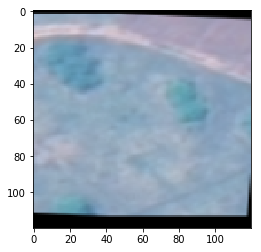

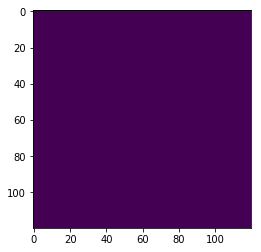

89 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


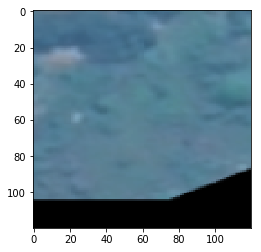

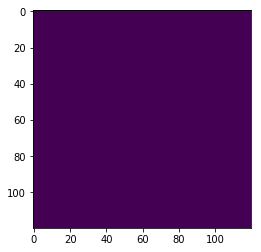

90 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


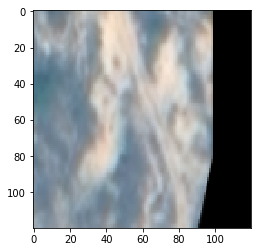

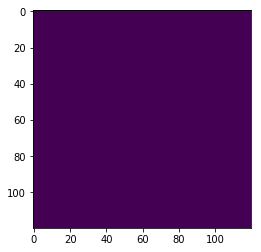

91 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


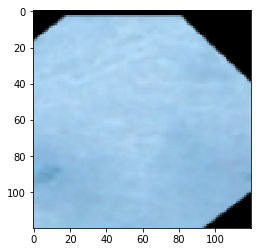

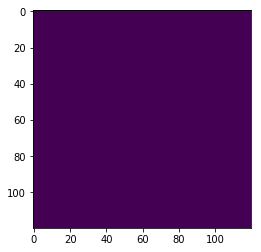

92 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


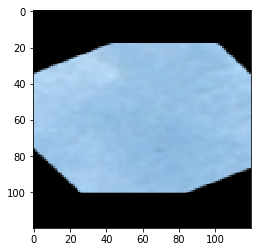

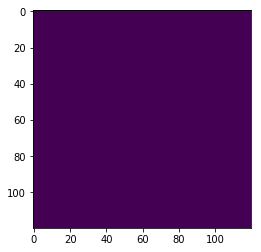

93 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


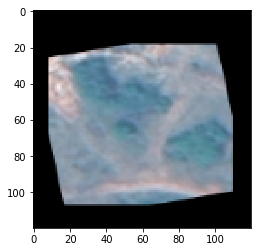

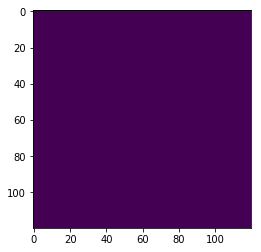

94 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


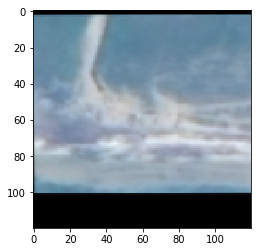

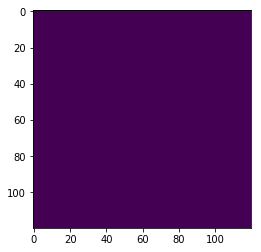

95 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


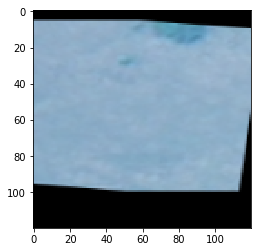

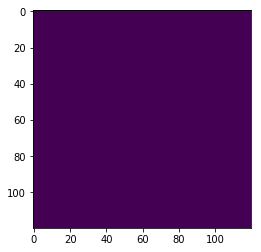

96 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


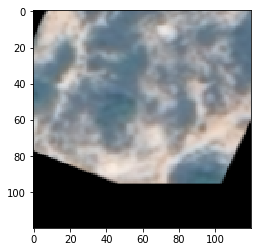

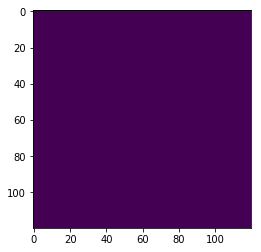

97 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


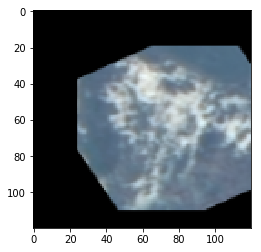

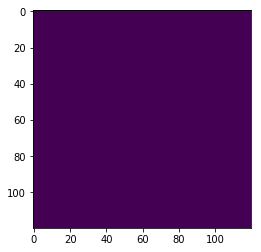

98 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


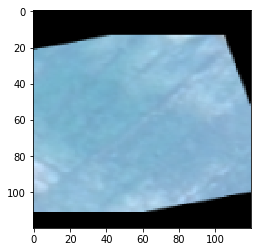

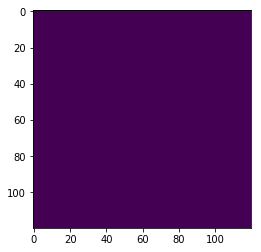

99 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


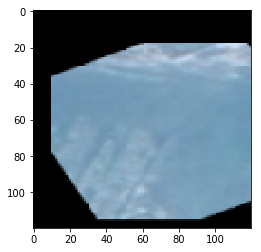

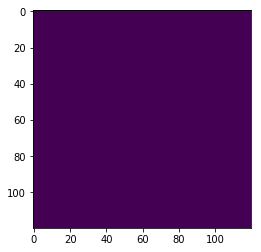

100 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


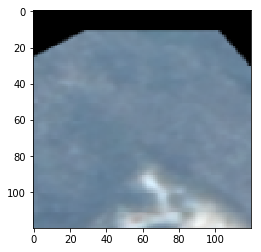

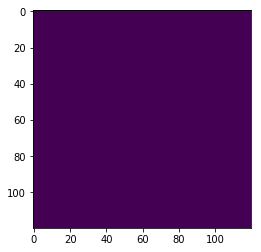

101 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


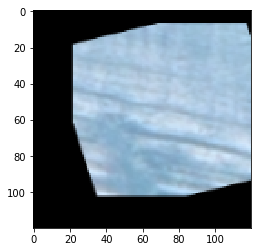

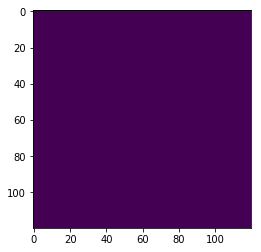

102 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


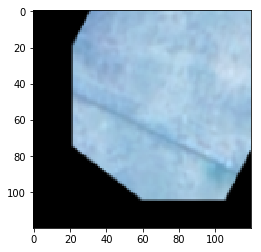

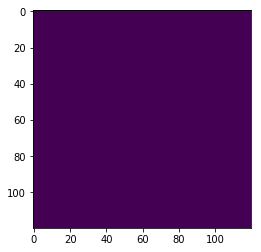

103 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


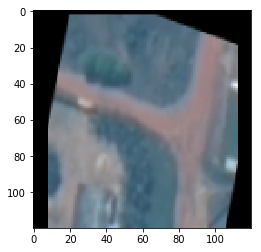

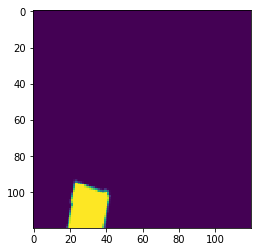

104 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


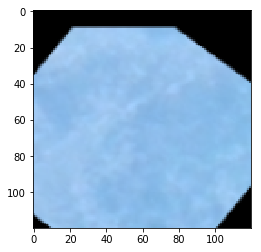

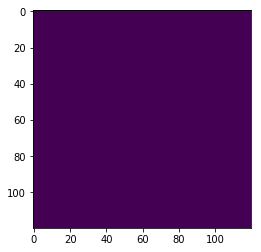

105 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


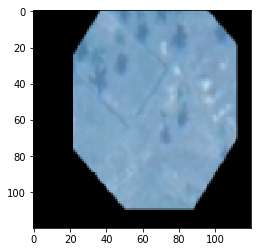

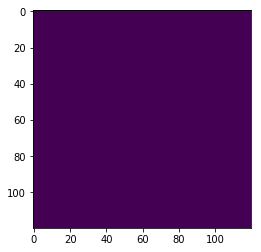

106 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


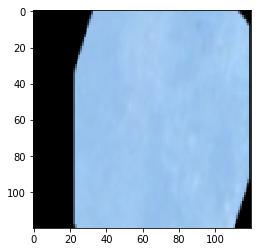

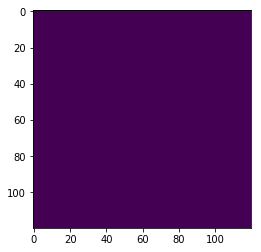

107 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


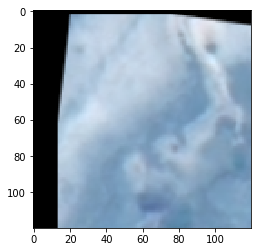

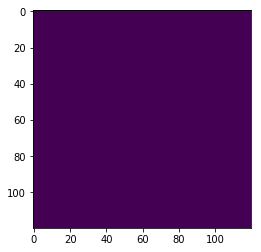

108 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


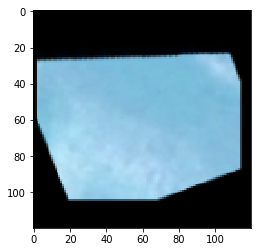

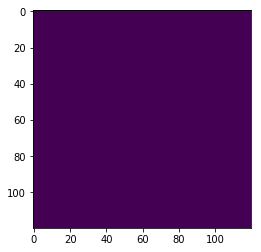

109 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


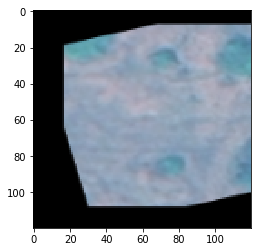

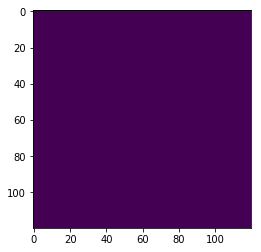

110 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


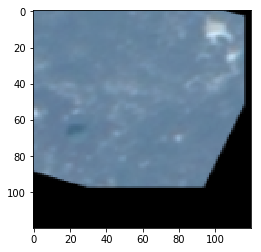

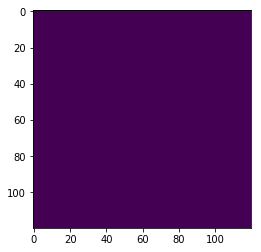

111 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


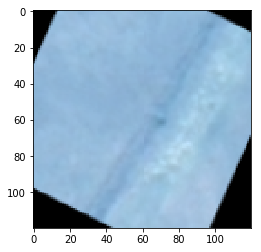

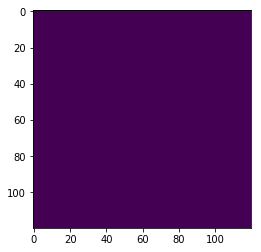

112 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


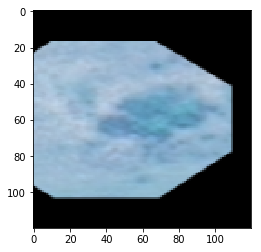

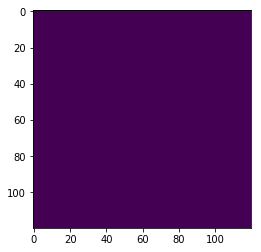

113 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


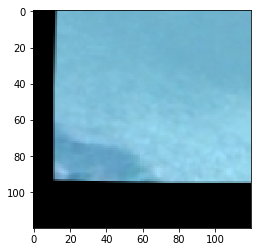

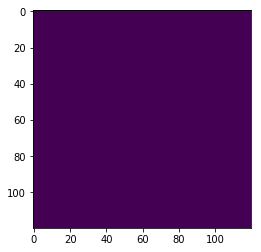

114 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


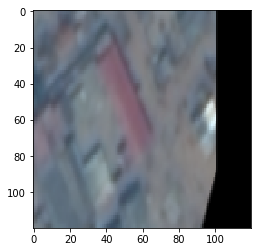

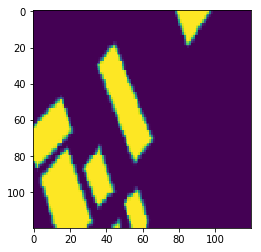

115 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


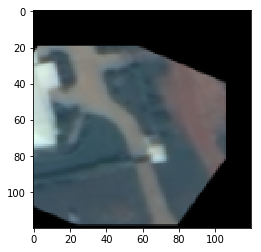

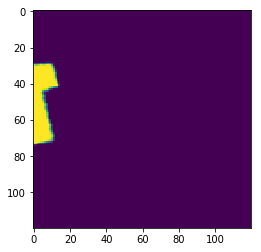

116 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


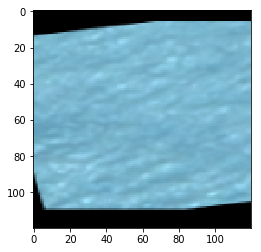

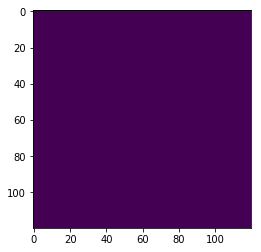

117 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


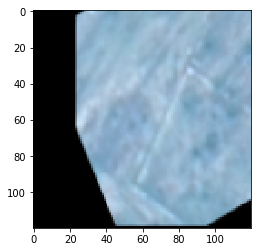

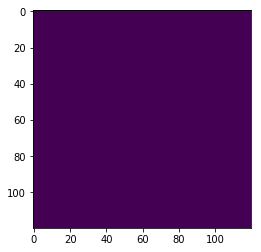

118 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


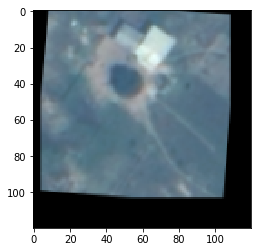

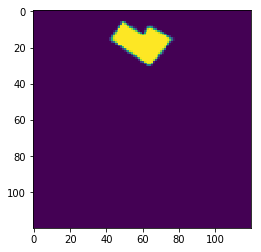

119 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


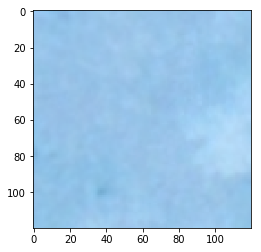

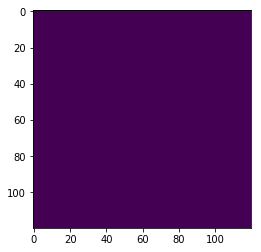

120 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


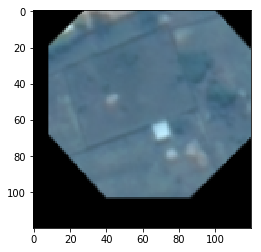

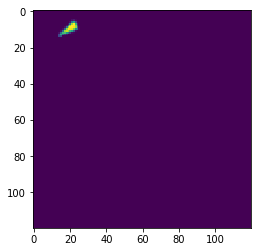

121 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


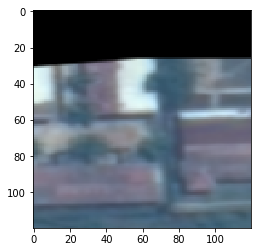

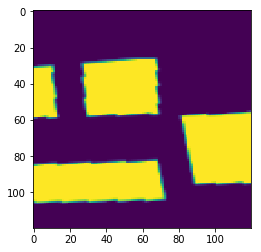

122 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


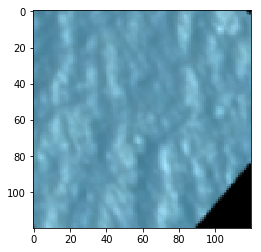

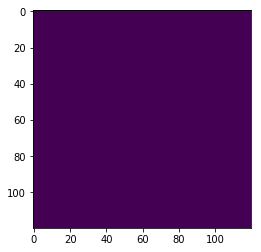

123 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


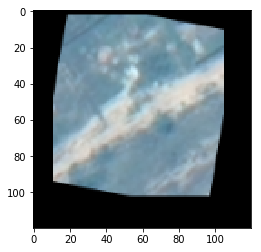

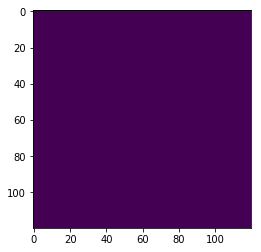

124 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


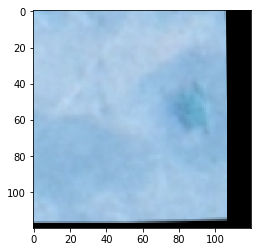

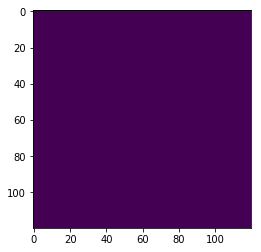

125 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


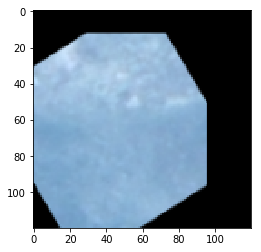

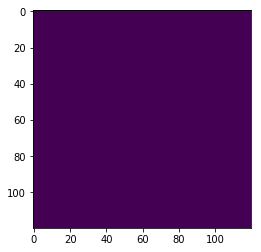

126 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


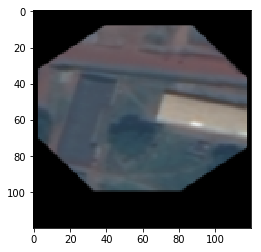

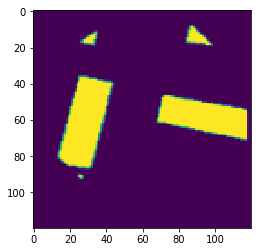

127 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


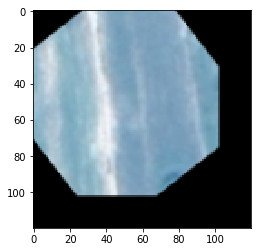

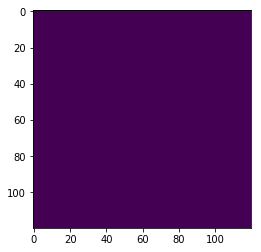

128 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


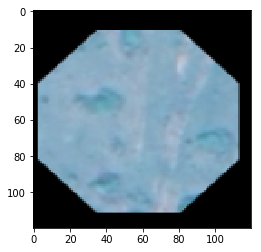

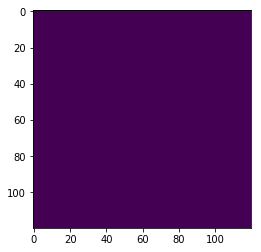

129 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


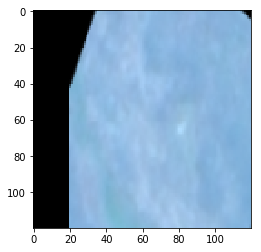

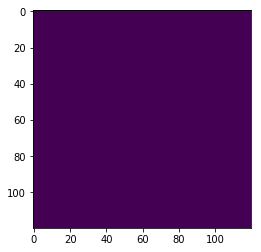

130 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


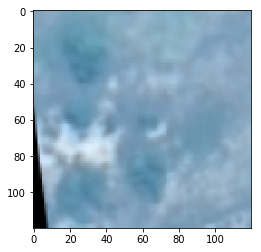

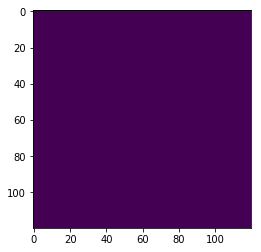

131 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


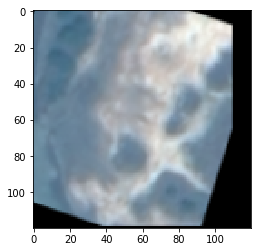

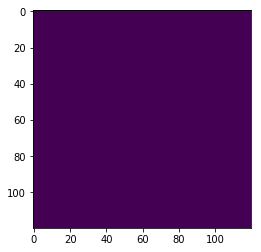

132 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


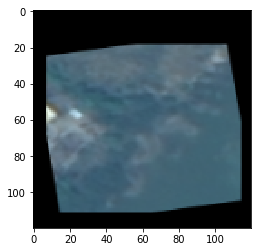

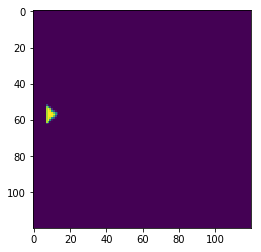

133 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


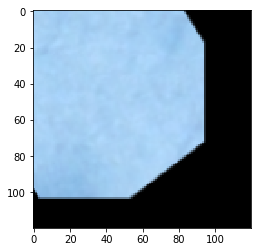

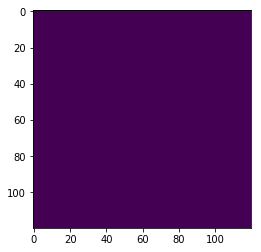

134 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


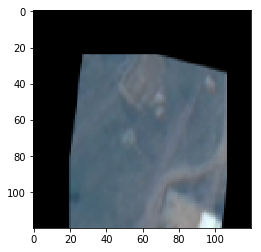

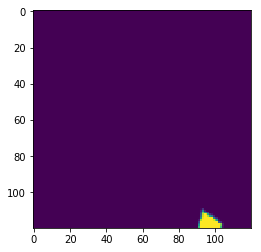

135 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


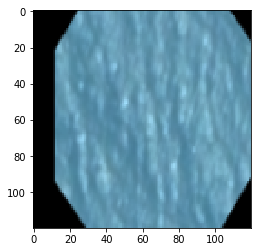

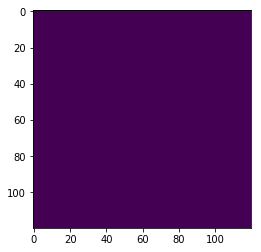

136 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


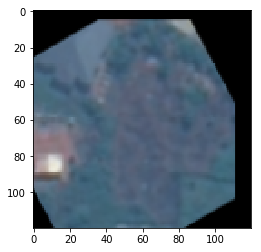

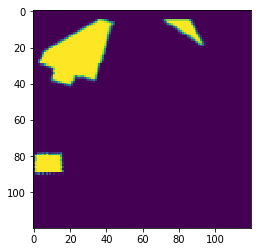

137 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


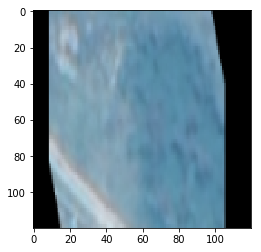

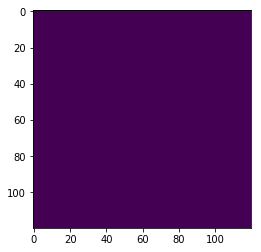

138 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


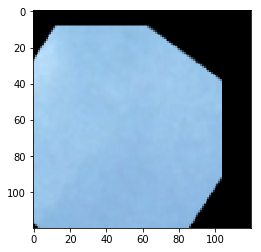

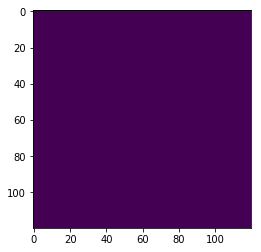

139 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


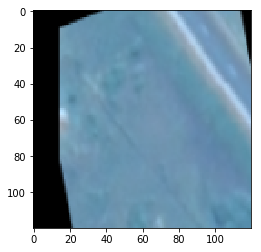

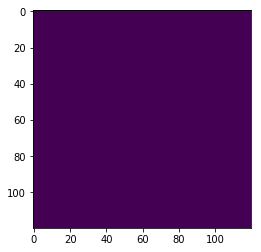

140 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


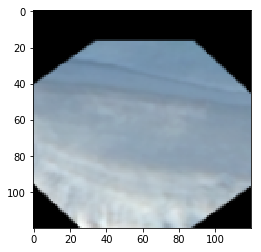

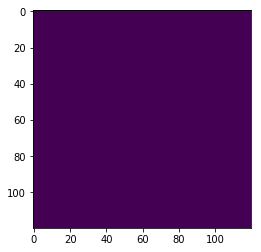

141 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


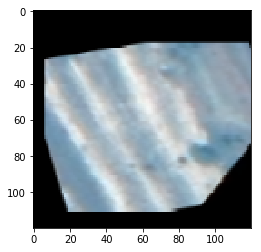

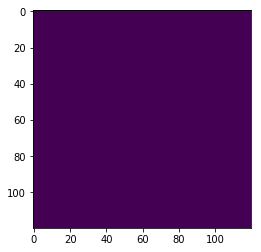

142 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


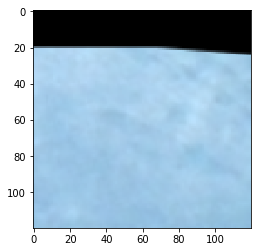

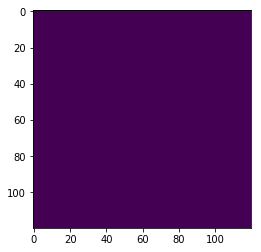

143 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


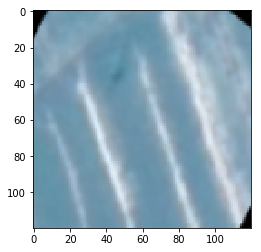

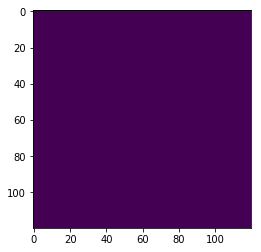

144 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


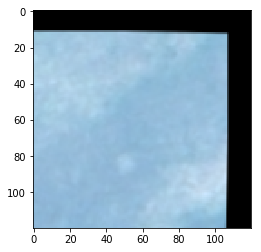

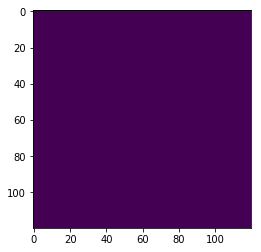

145 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


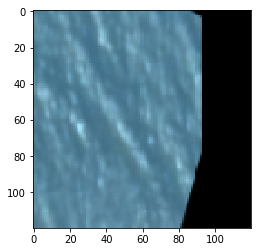

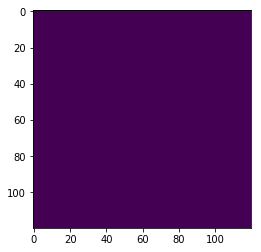

146 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


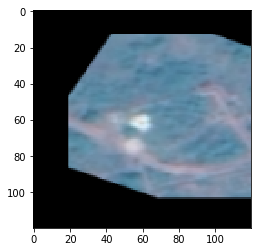

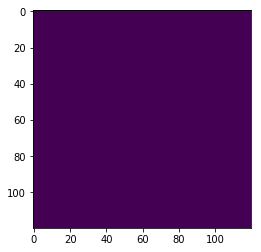

147 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


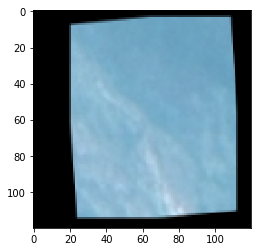

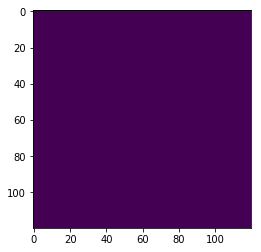

148 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


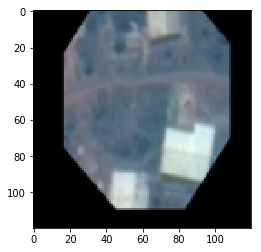

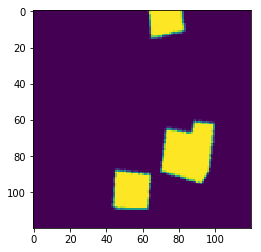

149 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


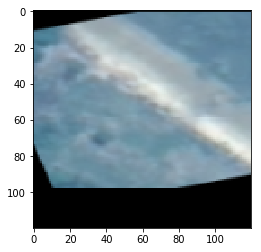

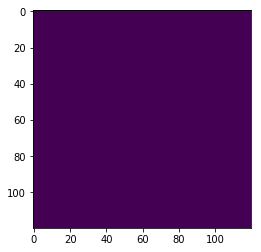

150 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


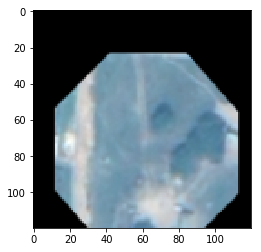

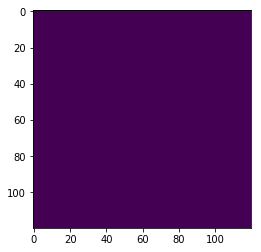

151 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


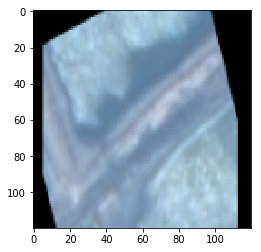

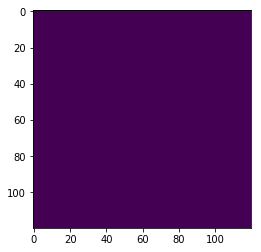

152 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


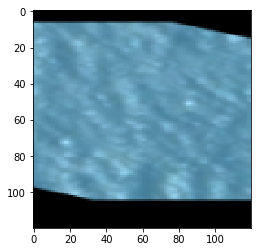

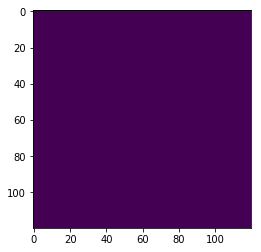

153 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


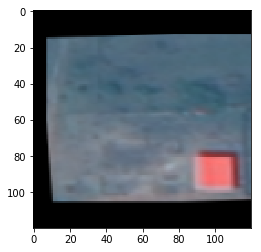

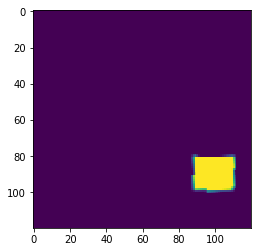

154 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


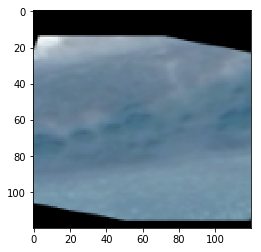

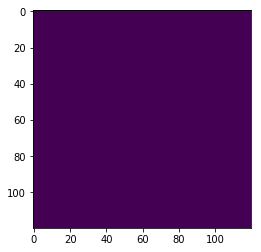

155 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


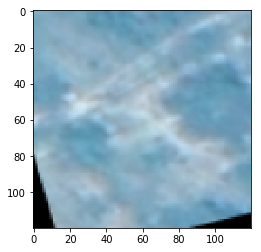

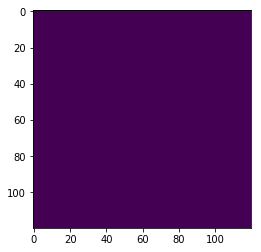

156 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


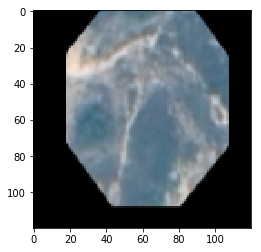

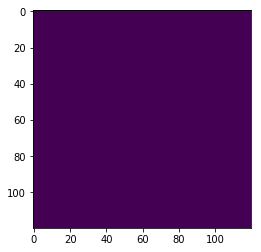

157 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


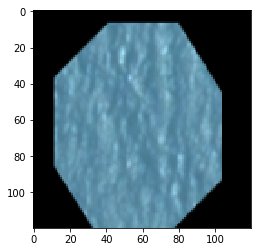

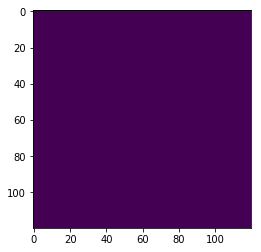

158 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


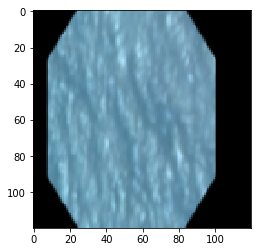

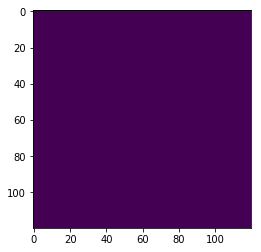

159 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


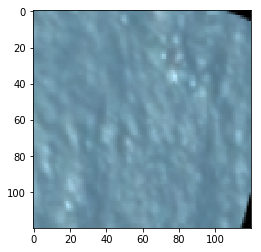

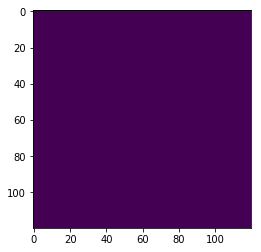

160 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


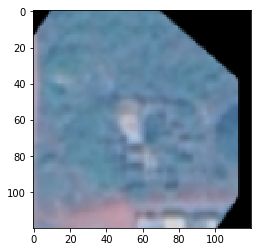

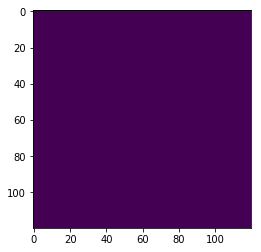

161 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


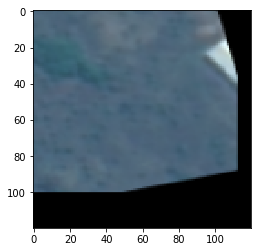

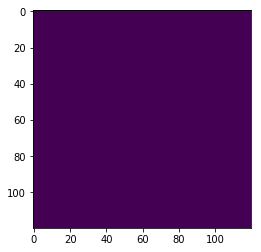

162 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


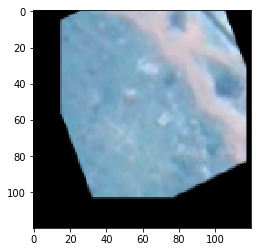

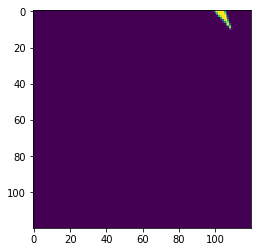

163 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


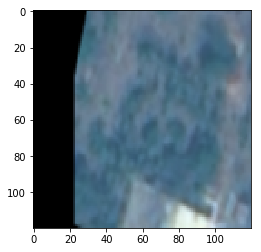

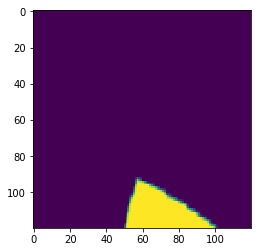

164 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


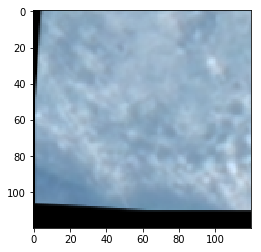

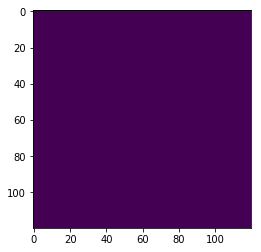

165 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


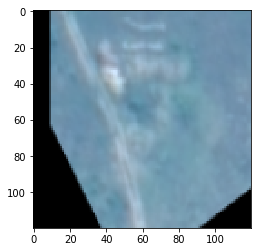

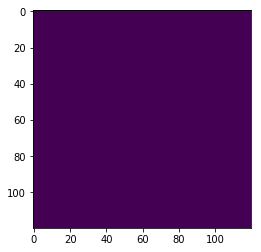

166 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


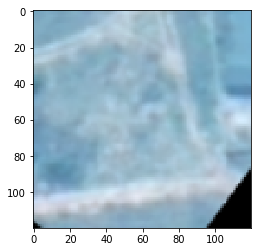

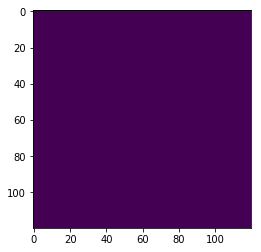

167 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


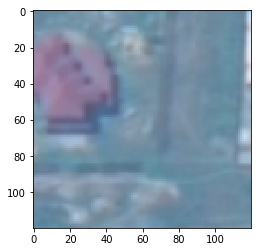

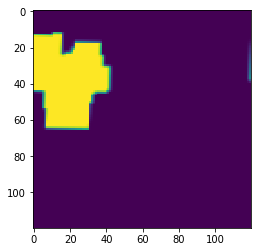

168 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


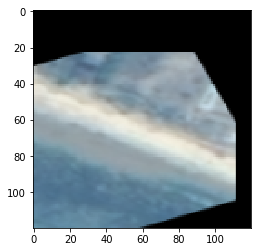

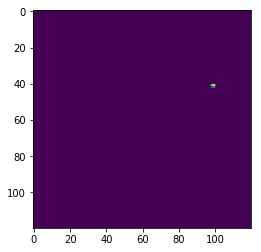

169 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


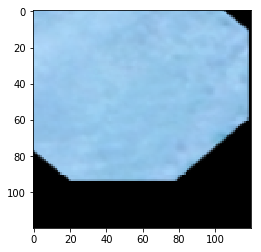

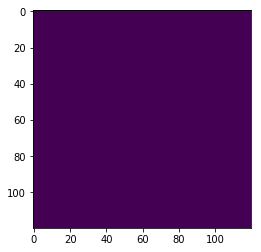

170 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


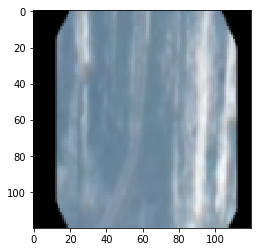

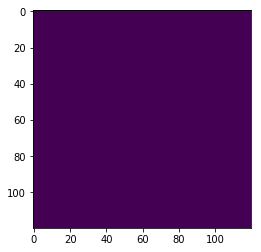

171 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


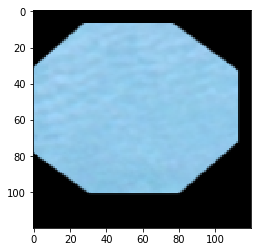

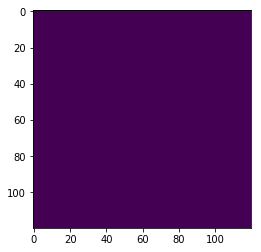

172 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


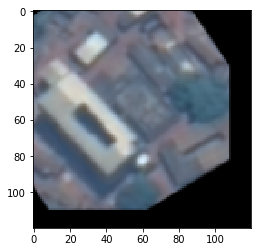

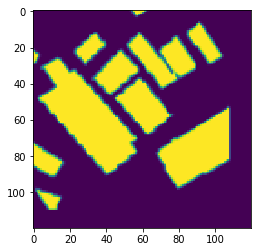

173 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


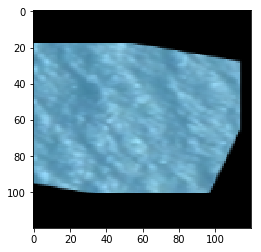

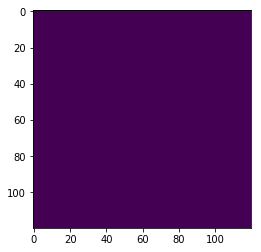

174 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


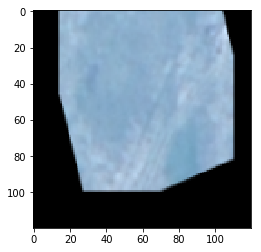

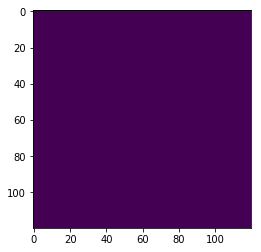

175 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


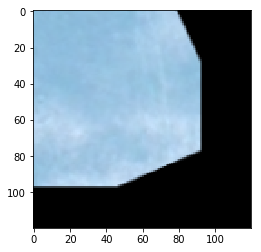

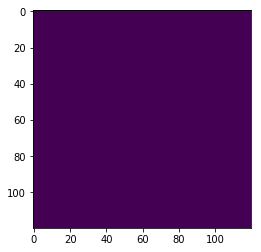

176 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


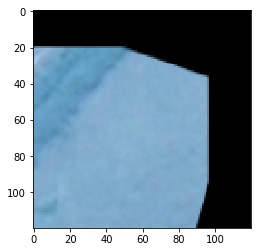

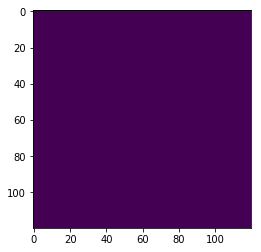

177 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


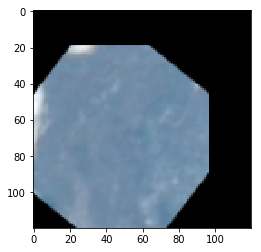

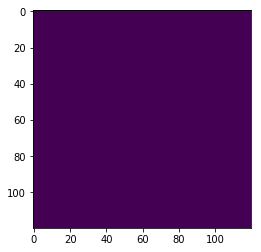

178 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


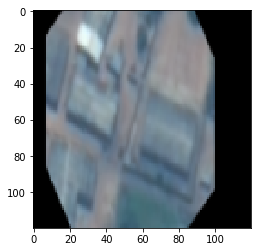

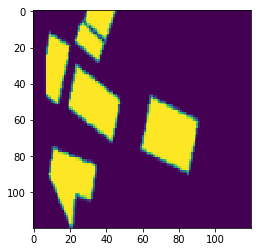

179 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


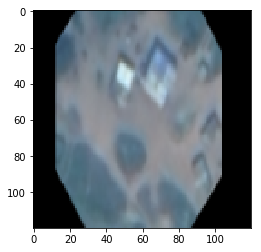

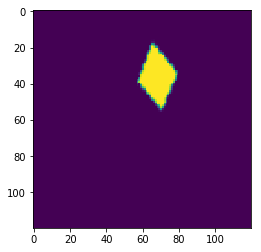

180 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


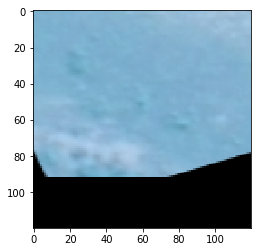

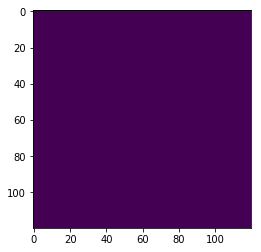

181 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


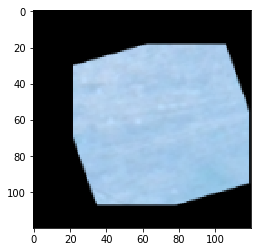

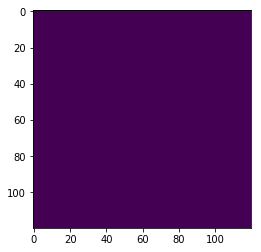

182 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


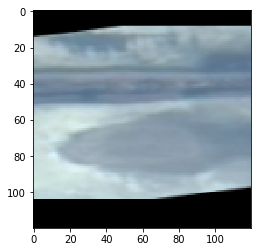

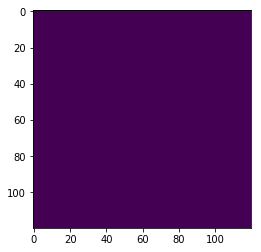

183 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


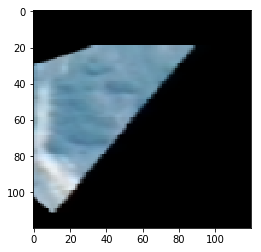

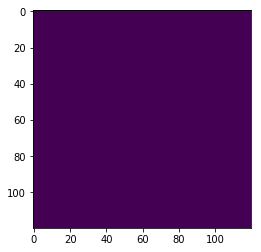

184 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


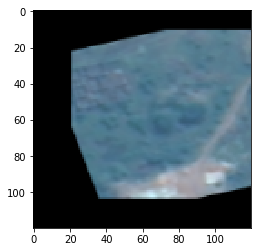

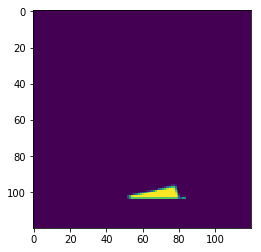

185 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


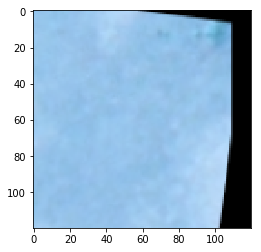

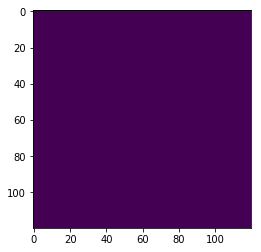

186 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


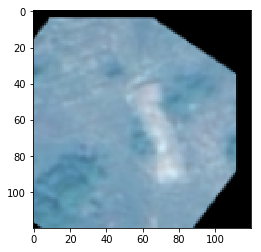

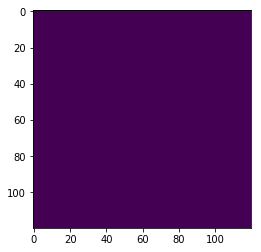

187 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


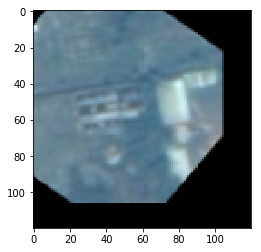

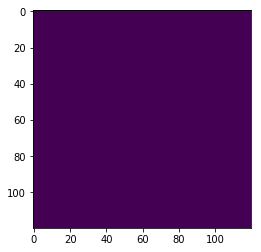

188 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


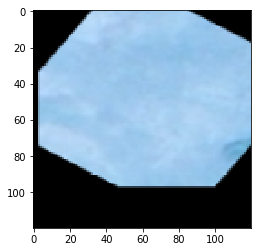

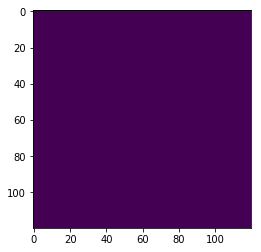

189 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


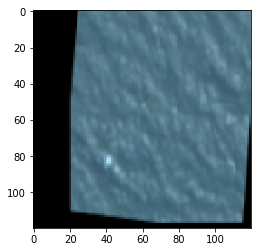

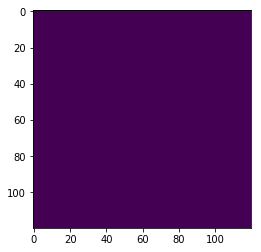

190 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


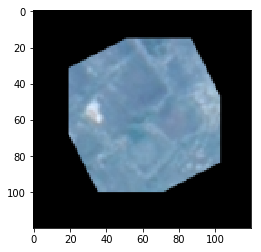

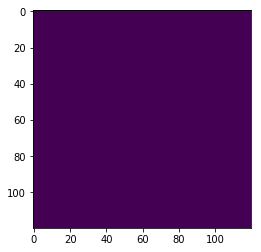

191 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


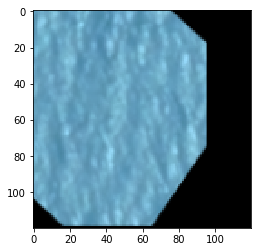

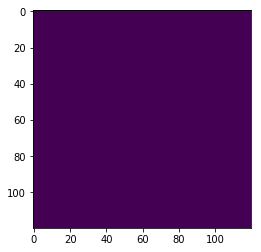

192 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


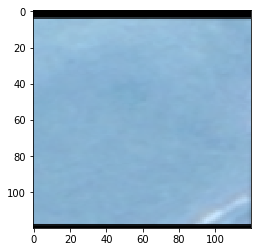

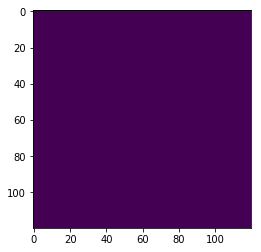

193 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


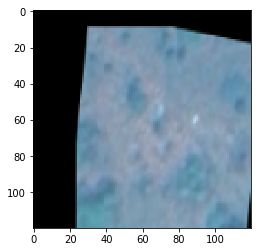

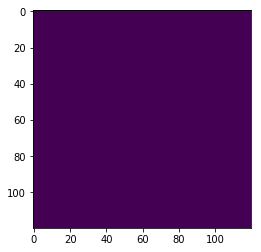

194 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


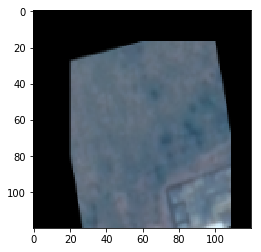

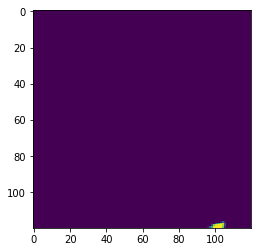

195 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


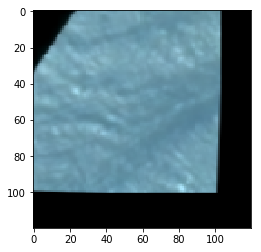

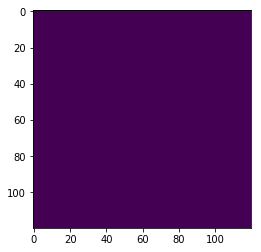

196 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


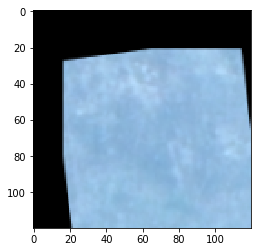

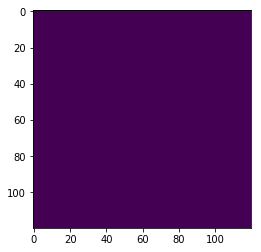

197 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


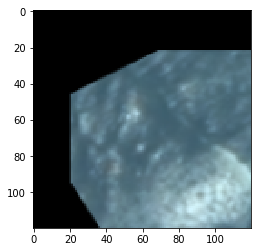

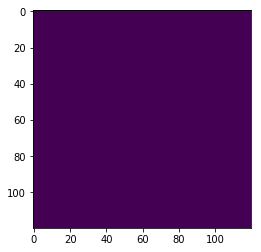

198 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


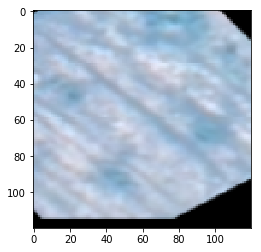

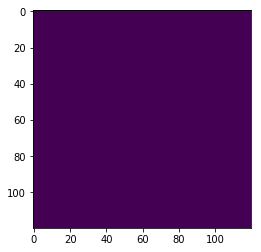

199 torch.Size([1, 120, 120, 9]) torch.Size([1, 120, 120, 2])


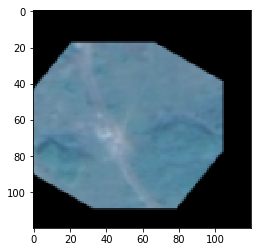

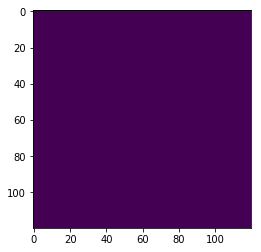

In [16]:
root_folder = '../2_DATA_GHANA/DATASET/120_x_120_8_pansh/TEST/'
# root_folder ='/scratch/SPACENET_DATA_PROCESSED/DATASET/120_x_120_8_bands_pansh/TEST/'

composed=transforms.Compose([Rotate(90),Rescale(0.25),Flip(0.5),ToTensor()])
generator=Dataset_sat.from_root_folder(root_folder,NB_CLASSES,max_data_size=200)
print(generator.__len__())
generator_aug=Dataset_sat.from_root_folder(root_folder,NB_CLASSES,max_data_size=200,transform=composed)
print(generator_aug.__len__())

dataloader = DataLoader(generator, batch_size=4,shuffle=True, num_workers=1)
print(dataloader.__len__())
dataloader_aug = DataLoader(generator_aug, batch_size=1,shuffle=True, num_workers=1)
print(dataloader_aug.__len__())


# for i in range(len(generator)):
#     sample = generator. __getitem__(i)
#     print(i, sample['input'].shape, sample['groundtruth'].shape)
#     plt.imshow(sample['input'][:,:,0])
#     plt.show()
#     plt.imshow(sample['groundtruth'][:,:,1])
#     plt.show()
#     trans=Flip(0.5)
#     sample_t=trans(sample)
#     plt.imshow(sample_t['input'][:,:,0])
#     plt.show()
    
#     if i == 10:
#         break
        

for i_batch,sample_batch in enumerate(dataloader_aug):
    
#     if (sample_batch['input'][0,:,:,0]).mean()==0:
    print( i_batch,sample_batch['input'].size(),
          sample_batch['groundtruth'].size())

    pansharp=np.stack((np.asarray(sample_batch['input'])[:,:,:,5],np.asarray(sample_batch['input'])[:,:,:,3],np.asarray(sample_batch['input'])[:,:,:,2]),axis=3)
    plt.imshow(pansharp[0,:,:,:])
#plt.imshow(sample_batch['input'][0,:,:,0])
    plt.show()
    plt.imshow(sample_batch['groundtruth'][0,:,:,1])
    plt.show()

    
    
